## Homework №2

### Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [0]:
import string

In [0]:
try:
    with open('../../datasets/Shakespeare_sonnets/sonnets.txt', 'r') as iofile:
        text = iofile.readlines()
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt -nc
    with open('sonnets.txt', 'r') as iofile:
        text = iofile.readlines()

File ‘sonnets.txt’ already there; not retrieving.



In [0]:
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [0]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')


OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [0]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [0]:
# dict <index>:<char>
idx_to_token = { index : char for index, char in enumerate(tokens) }
# Your great code here

# dict <char>:<index>
token_to_idx = { char: index for index, char in enumerate(tokens) }
# Your great code here


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

import torch, torch.nn as nn
import torch.nn.functional as F
from random import sample

num_tokens = len(tokens)

text_splitted = [' ' + word.strip()  for word in text.split('\n')]
MAX_LENGTH = max(map(len,text_splitted))
print ("MAX_LENGTH", MAX_LENGTH)


class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """

        x_emb = self.embedding(x) # vfnhbwf embedding size

        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=1) # YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) # YOUR CODE HERE   
        h_next = torch.tanh(h_next) # YOUR CODE HERE
              
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)# YOUR CODE               
        return h_next, F.log_softmax(logits, -1)

    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)



def to_matrix(text, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    """Casts a list of strings into rnn-digestable matrix"""
    max_len = max_len or max(map(len, text))
    text_ix = np.zeros([len(text), max_len], dtype) + pad
    
    for i in range(len(text)):
        line_ix = [token_to_idx[c] for c in text[i]]
        text_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        text_ix = np.transpose(text_ix)

    #print('to_matrix', text, text_ix)

    return text_ix


def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
    
    return torch.stack(logprobs, dim=1)

MAX_LENGTH 61


In [0]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []


for i in range(1000):
    batch_ix = to_matrix(sample(text_splitted, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]# YOUR CODE HERE
    actual_next_tokens = batch_ix[:, 1:]# YOUR CODE HERE

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    ) # YOUR CODE HERE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    # YOUR CODE HERE
    
    history.append(loss.data.numpy())


assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."


Plot the loss function (axis X: number of epochs, axis Y: loss function).

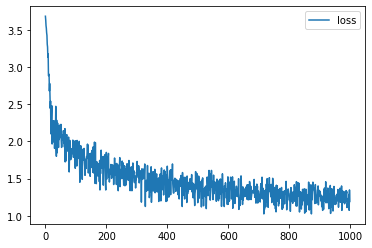

In [0]:
from IPython.display import clear_output
# Your plot here
clear_output(True)
plt.plot(history,label='loss')
plt.legend()
plt.show()

In [0]:
def generate_sample(char_rnn, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state,out = char_rnn(x_sequence[:, i], hid_state)
    
    
    for _ in range(max_length - len(seed_phrase)):
        hid_state,out = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])


In [0]:
# An example of generated text.
char_rnn.eval()
temperature = [0.1, 0.2,0.5,1.0, 2.0]

for tmp in temperature:
  print('temperature:', tmp)
  for i in range(0,8):  
    print(generate_sample(char_rnn,max_length=64, temperature=tmp))
  print('\n')

temperature: 0.1
 hellon the the the the the the the the the the the the the the 
 hellow the the the the the the the the the the the the the the 
 hellour the the the the the the the the the the the the the the
 hellon the the the the the the the the the the the the the the 
 hellon the the the the the the the the the the me the the the t
 hellow the the the the the the the the the the the the the the 
 hellon the the the the the the the the the the the the the the 
 hellon the the the the the the the the the the the the the the 


temperature: 0.2
 hello so the the the the my the the the the the the the the sta
 hellong the singe seart in the the the the the the the the the 
 hellon that the the the the my me the me the that the so the th
 hellon the the the the mere the me in the the the the the the t
 hellos the me the the seart the the the the the the the the so 
 hellour so the seart the the in the wath so the the the the tho
 hellow the the the the the in the the so the the the 

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

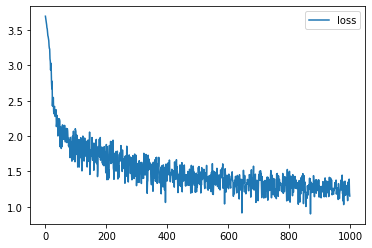

In [0]:
class MyModel(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.lstm(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp



model = MyModel()
opt = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss()
history = []

for i in range(1000):
    batch_ix = to_matrix(sample(text_splitted, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model(batch_ix)
    
    loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))

    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [0]:
def generate_sample2(char_rnn, seed_phrase=' hello', max_length=64, temperature=1.0):   
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

    for i in range(len(seed_phrase) - 1):
        next = torch.tensor([[x_sequence[:, i]]], dtype=torch.int64)
        out = char_rnn(next)
    
    for _ in range(max_length - len(seed_phrase)):
        next = torch.tensor([[x_sequence[:, -1]]], dtype=torch.int64)
        out = char_rnn(next)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next[0])
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

model.eval()

temperature = [0.1, 0.2,0.5,1.0, 2.0]

for tmp in temperature:
  print('temperature:', tmp)
  for i in range(0,8):  
    print(generate_sample2(model,max_length=64, temperature=tmp))
  print('\n')

temperature: 0.1
 hellounowhenononoronoungrenonounonononononounounonowhenounonoun
 hellounonowhenowhenounowhenoungrowhengvinounounonowhenonounonow
 hellofenong. anounoungrounonginononowhenonof thenounonowhenonow
 helloungvinowhenonowhenowhenowhenononononowhenowhenounowhenowhe
 hellononononounenounowhenounonoungvinounononounounowhenowhenono
 hellonofounowhenowhenoronouthenonowhenonononononowhenowhowhenon
 hellounounothenonononounonounonounonowhenuthenounounowhenounowh
 hellowhenononounonowhengrounonowhenonowhenowhenonowhenowheng. t


temperature: 0.2
 hellounounonounofong
nowhevonowhencined, therouthespinovingvino
 hellonunonovinowhenonowowhenonowhenowheng(henenowhenononowhethe
 hellowhethanowhenowhangqenounovangranenuno!angkenononowhenonono
 hellounouthenosanononenino thedenof thesthenghenoungrerowinowhe
 hellounonoununouthenounenongvinongy  theronouninounongrinorouth
 hellounowhengzwhakevoungrothanovinounouno!,  athenounenowhenlow
 hello!inenowhervinongvinghanenoununononangy thenovine

Более поэтической модель явно не получилась, но в целом, чем выше температура, тем более "равномернее" выбор. При температуре 0.1 мы используем только самый вероятный выбор, поэтому в тексте много циклов. При температуре 2.0 мы практически просто случайным образом выбираем следующий символ, так что тут больше на пьяного Шекспира похоже.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [0]:
# Saving and loading code here
filename = f'model.pth'

with open(filename, "wb") as fp:
    torch.save(model.state_dict(), fp)


model2 = MyModel()

with open(filename, "rb") as fp:
    model_state_dict = torch.load(fp, map_location="cpu")
    model2.load_state_dict(model_state_dict)


model2.eval()

temperature = [0.1, 0.2,0.5,1.0, 2.0]

for tmp in temperature:
  print('temperature:', tmp)
  for i in range(0,8):  
    print(generate_sample2(model2,max_length=64, temperature=tmp))
  print('\n')

temperature: 0.1
 hellononowhenowhenounounoungrounounonowhenowhenowhenonouthenout
 hellounowhenowhengrenonongrounowhenonowhenonounowhenong. ang(he
 hellonounonowhenounowhenounowhenongrengrengxxxxxxxxxxxxxxxvinou
 hellowhenononenonowhenonengrinowhenounenononounowhenonononounou
 hellowhenonowhenowhenononounowhenovinonowhenowhenenononounonowh
 hellounounonowhenonowhenonowhenowhenonenounongrenononowhenonoun
 hellovinounononononounonenonounowhenonounowhenonounonounowhenon
 hellowhenonouthengrinounoungrenounounounowhenowhenowhenowhenono


temperature: 0.2
 hellonononounowithenonungingpino!inouthevinowhen, anowhy  anono
 hellounounenungrinond'd;  thengingrinounglanongnouthenothenouth
 hellouthenovinovangrinoungrinounoungvanouthanounovinonono theng
 hellounonongunononouresongunoung-nouthenonounounchedenevingjino
 hellof blof thononeninununony thinononouthedenounghenenendanong
 hellonowhenonowherorowilonouthenowheshounouthenowheronowhenouno
 hellony. thovanonofowhenunofeswhenenonof anonounonden

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)